In [1]:
import dill

import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_path = "/home/bryanpu1/projects/aaai_2026/scaling_jax/results"
algo_name = "xland_ad"
run_name = "debug-06-02-25_14_46_07-3c1bc77f-9d04-4c25-8356-67dd1919b82a"

algo_name = "xland_dpt"
run_name = "debug-06-02-25_14_47_19-f8577fb0-3fb8-4664-8982-64d5985a9961"

algo_name = "xland_expi"
run_name = "debug-06-02-25_14_47_55-e68410db-d131-44d5-8720-a660d26eb3f8"

algo_name = "bandit_ad"
run_name = "debug-06-05-25_13_19_10-d1262807-a575-490d-abc8-35bae6930c8d"

In [3]:
data = dill.load(open(f"{base_path}/{algo_name}/{run_name}/eval_info.dill", "rb"))

In [4]:
data.keys()

dict_keys(['act_counts', 'episode_length', 'episode_return', 'env_params'])

In [5]:
data["act_counts"]

Array([[   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    0., 2048.],
       [   0.,    0.,    0.,    

[[1.76329749e-07 2.19849363e-01 9.98234272e-01 5.15207410e-01
  9.83272016e-01]
 [8.84841383e-01 2.49287076e-02 6.93565369e-01 1.99840277e-01
  7.22963512e-01]
 [9.83635426e-01 6.38788260e-05 4.90877719e-04 8.32320284e-03
  9.99999404e-01]
 [3.13391775e-01 3.40702099e-05 3.22822481e-02 7.02701986e-01
  3.13820085e-03]
 [1.11714326e-01 1.00000000e+00 7.97033548e-01 2.87643969e-01
  9.99959707e-01]
 [1.00000000e+00 2.61271834e-01 3.18650514e-01 9.60890889e-01
  3.01010128e-09]
 [6.85505942e-03 9.99905229e-01 8.97031665e-01 9.89532828e-01
  9.99456108e-01]
 [6.47014022e-01 1.29361346e-01 8.78308415e-01 3.20356280e-01
  4.58751708e-01]
 [1.00000000e+00 1.43525802e-04 9.99986649e-01 5.33912070e-02
  1.82104990e-01]
 [6.76286733e-03 4.15066635e-04 1.00000000e+00 7.00870931e-01
  1.71131164e-01]
 [1.82563701e-04 1.25272057e-10 1.49064159e-04 7.25864470e-01
  6.24834094e-03]
 [6.22774720e-01 9.60102156e-02 2.45868764e-03 3.62509782e-05
  4.53169830e-02]
 [9.99939561e-01 5.89256734e-02 8.623428

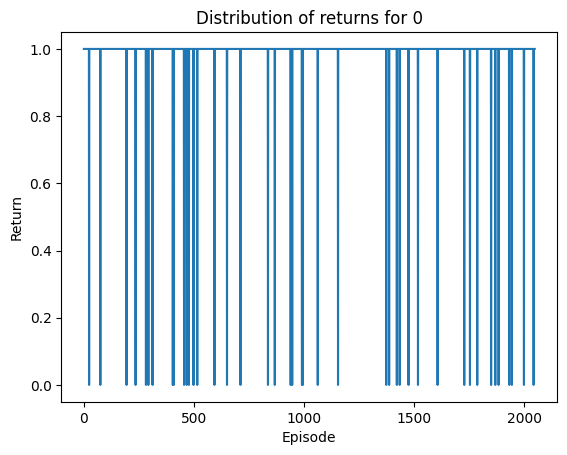

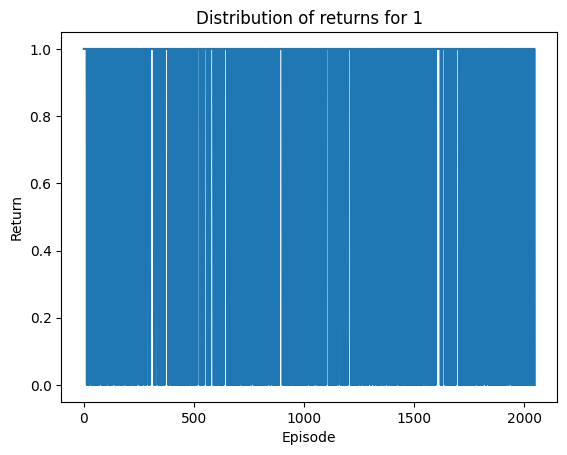

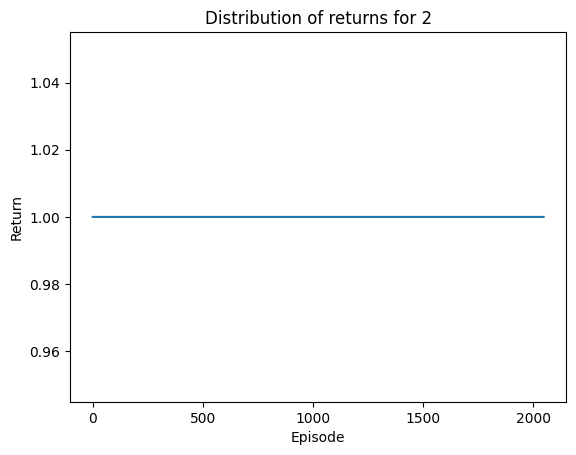

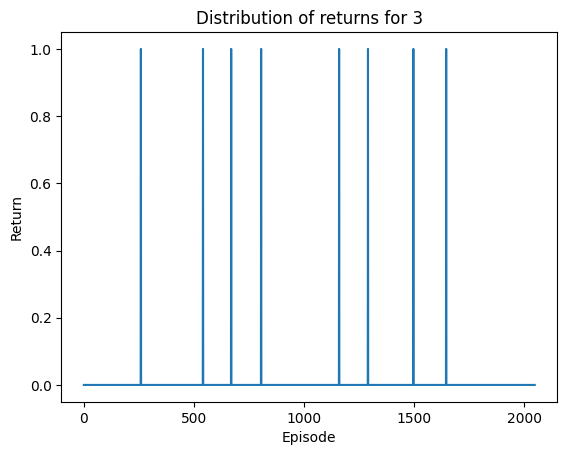

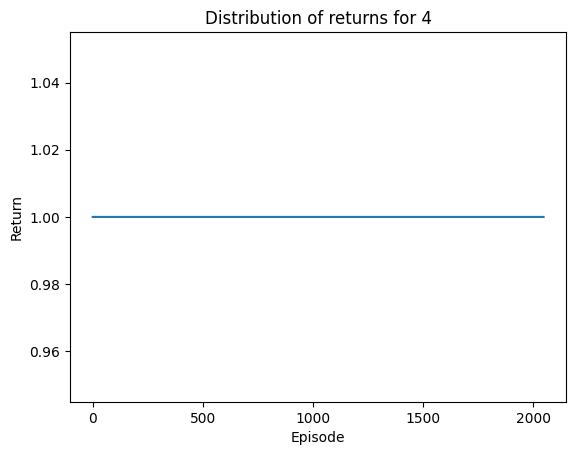

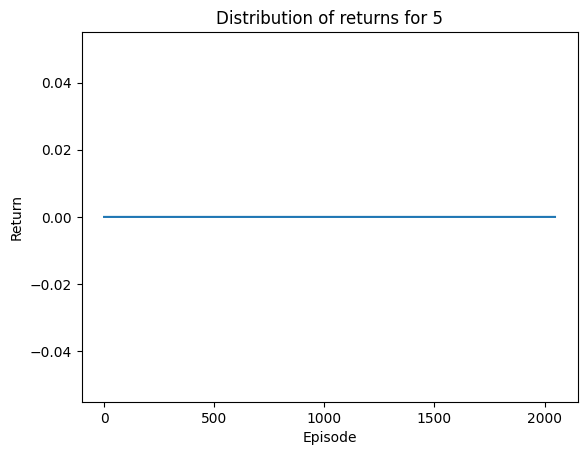

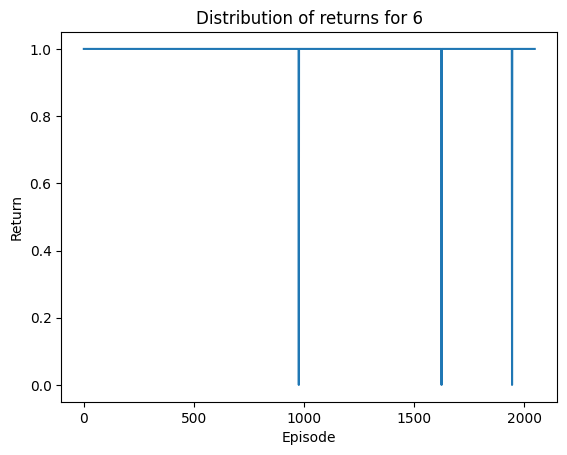

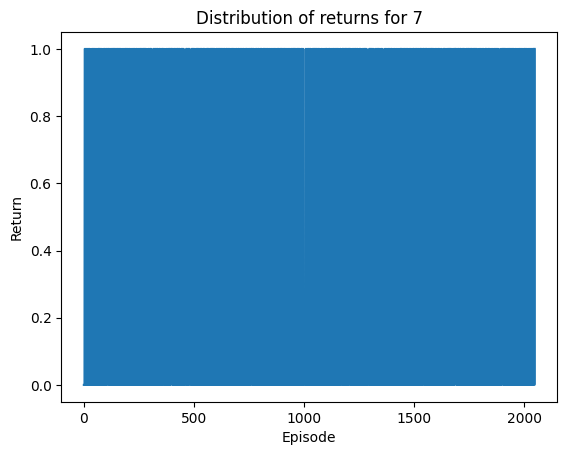

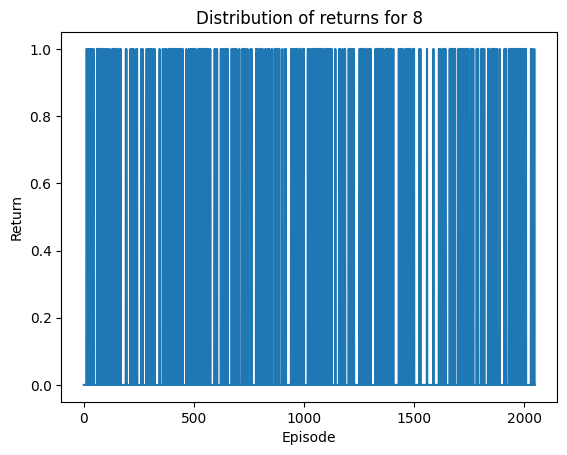

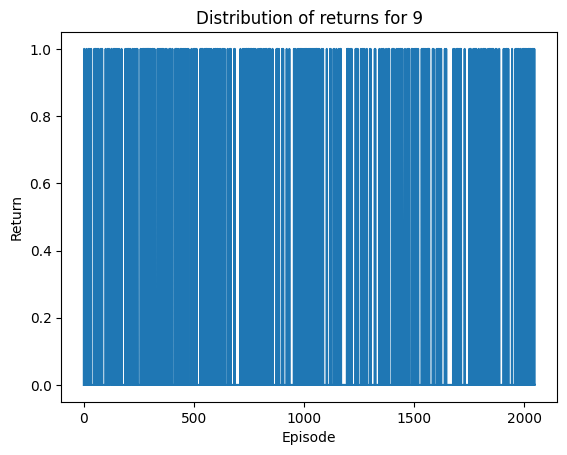

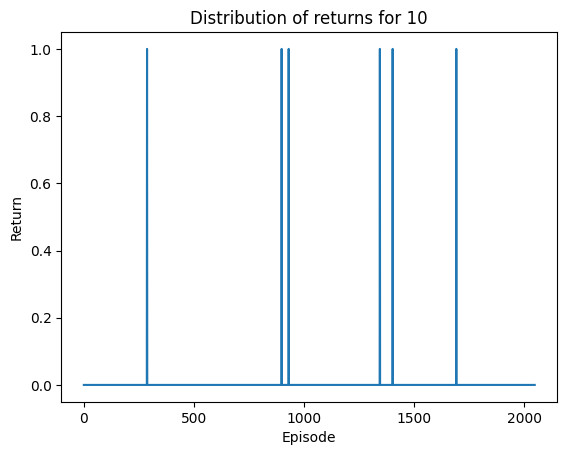

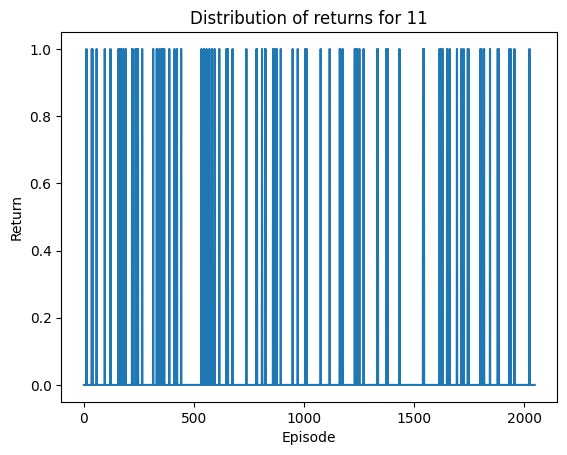

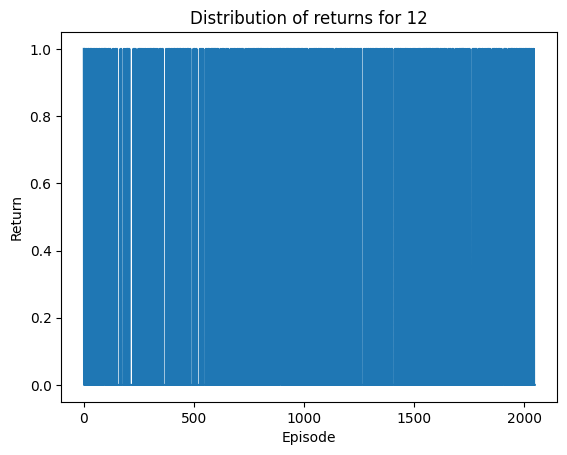

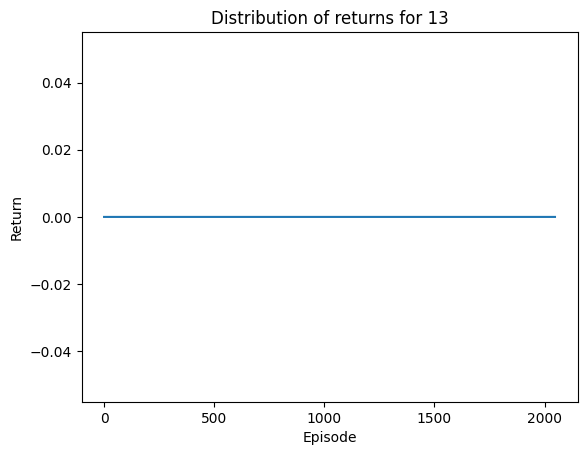

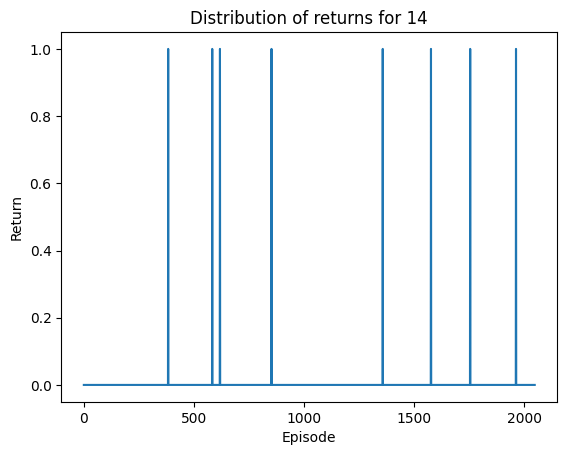

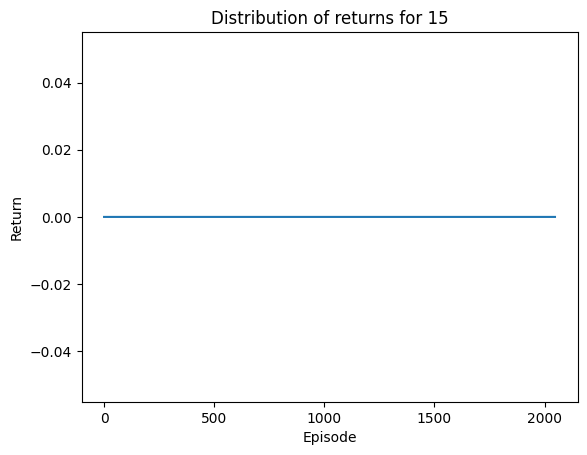

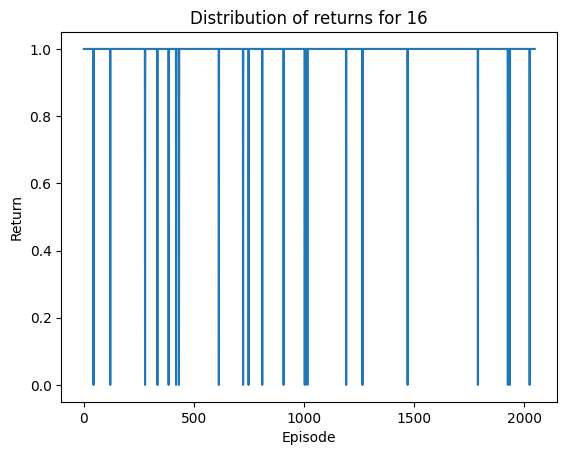

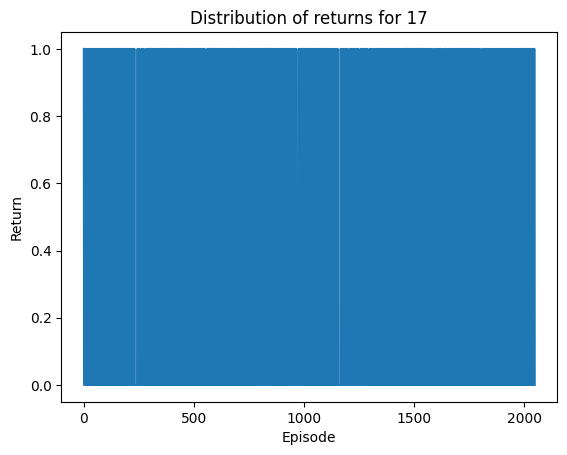

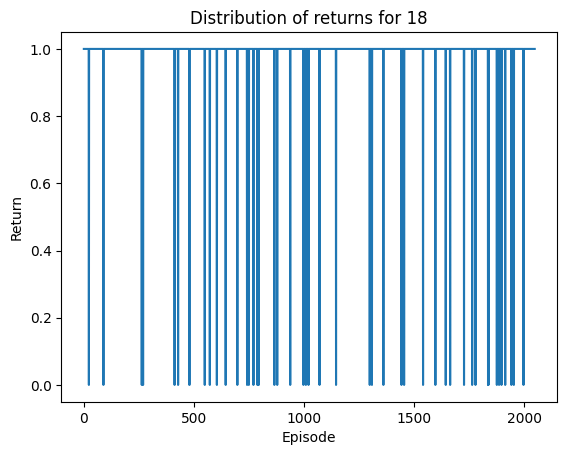

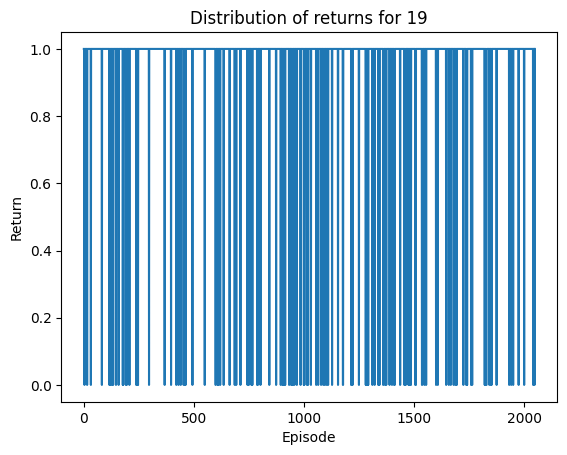

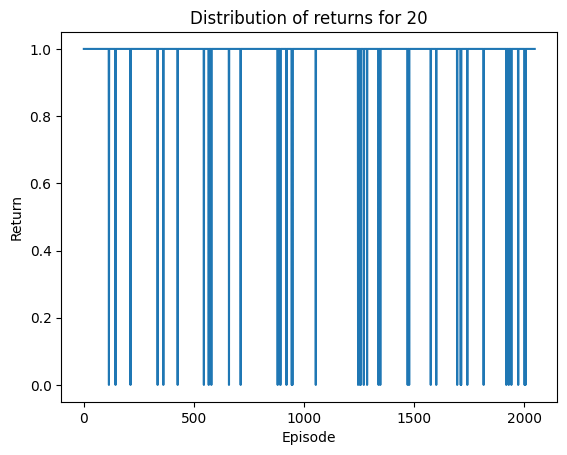

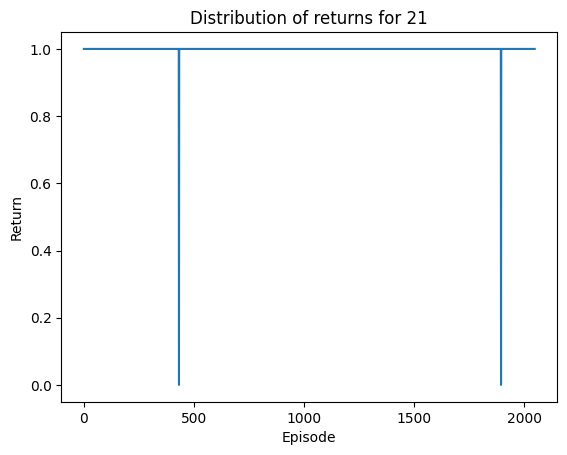

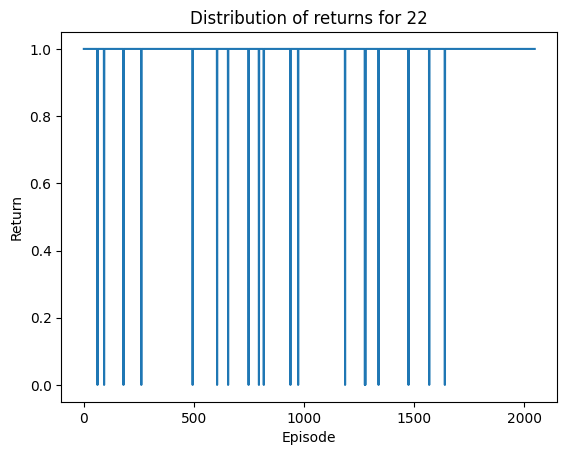

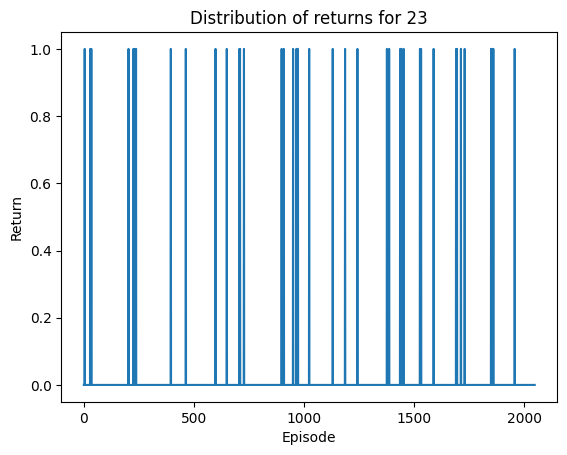

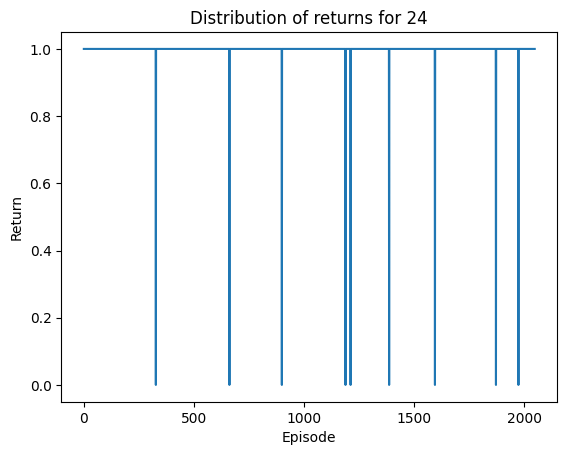

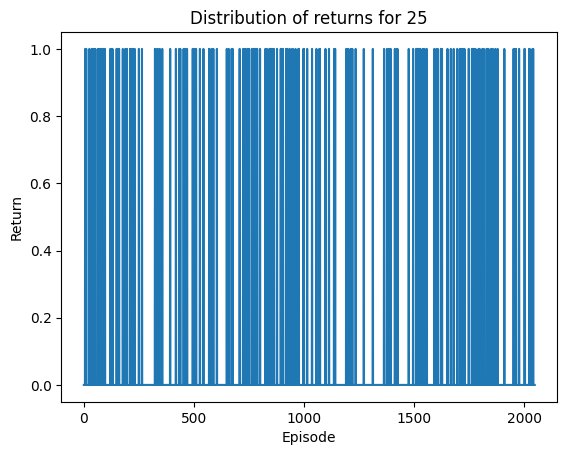

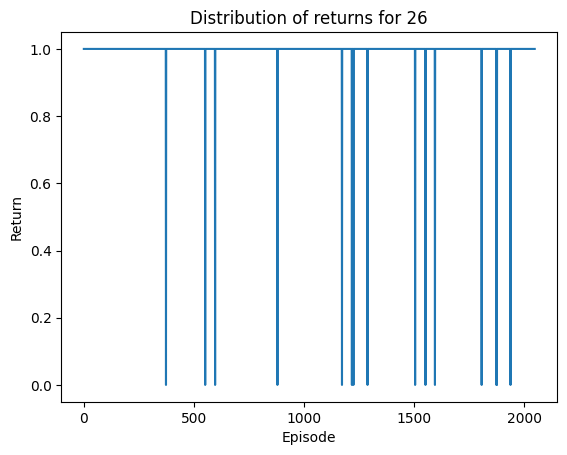

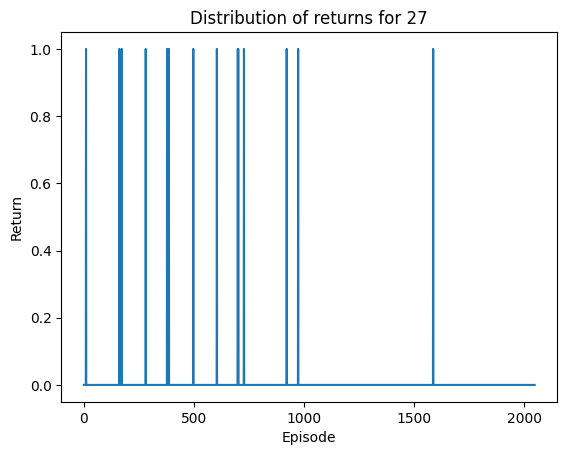

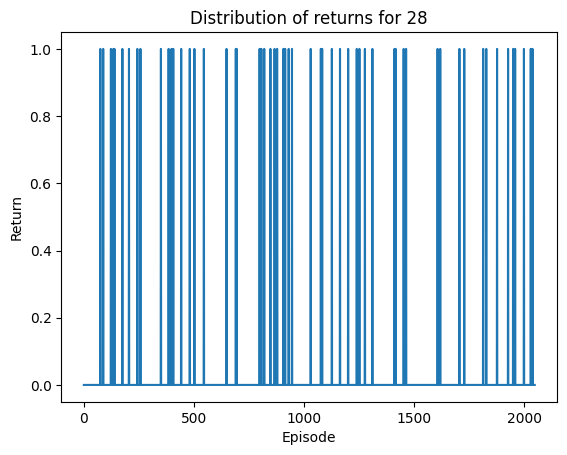

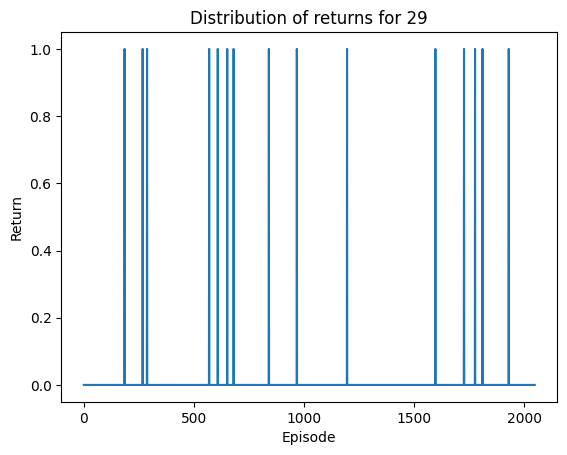

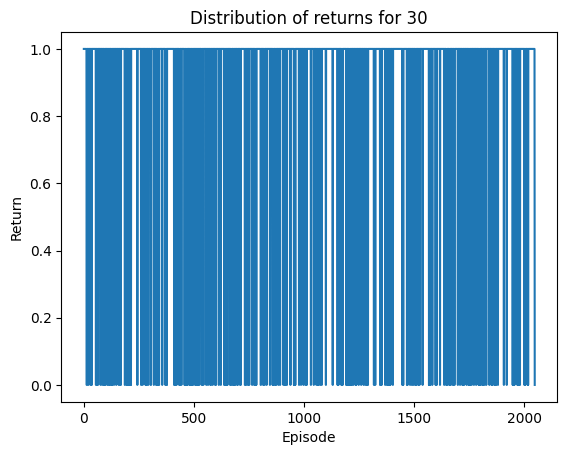

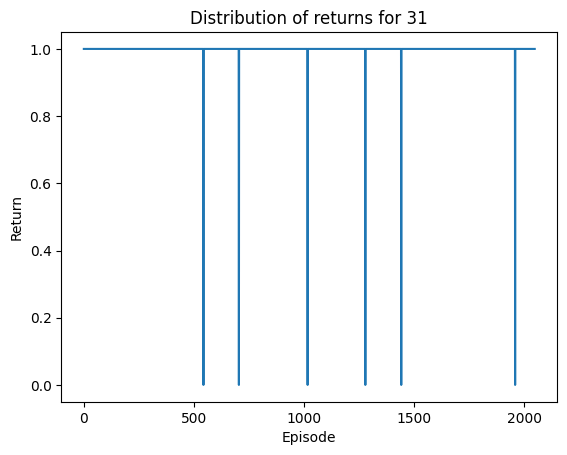

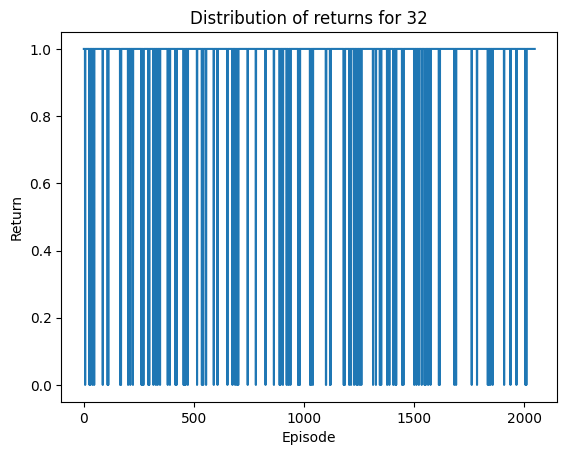

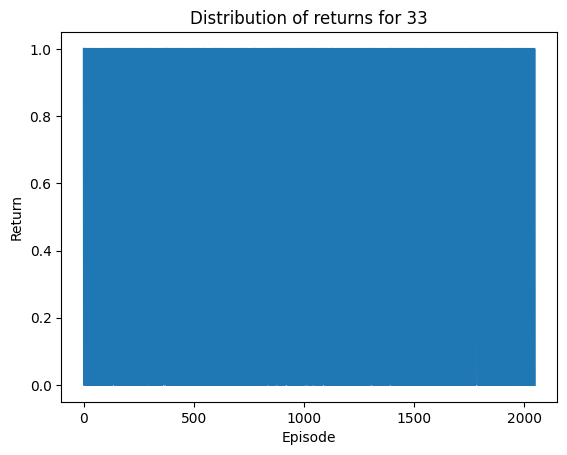

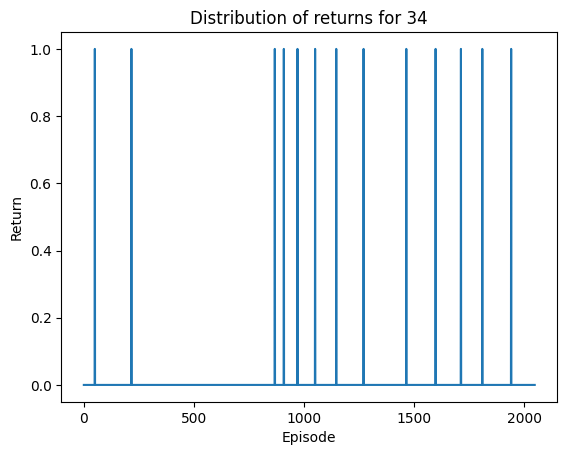

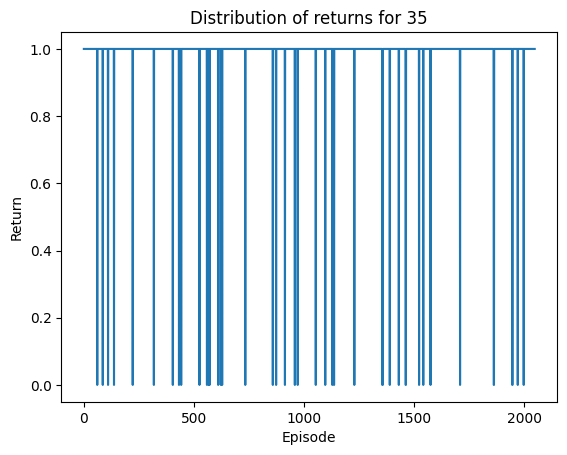

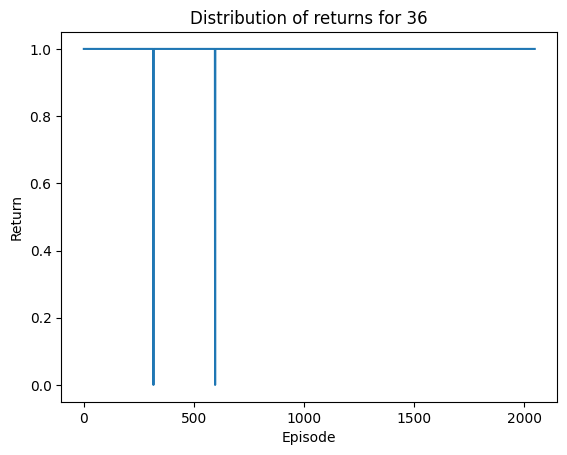

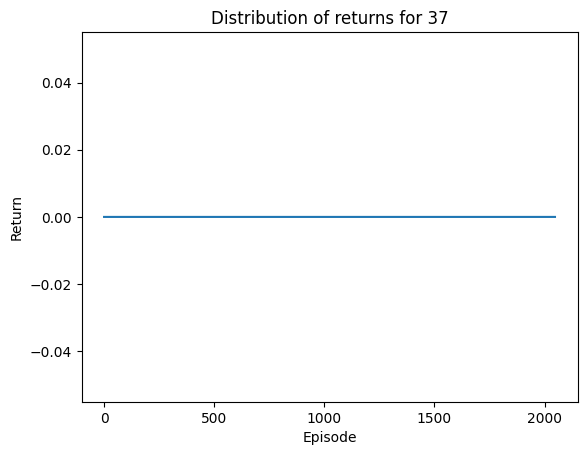

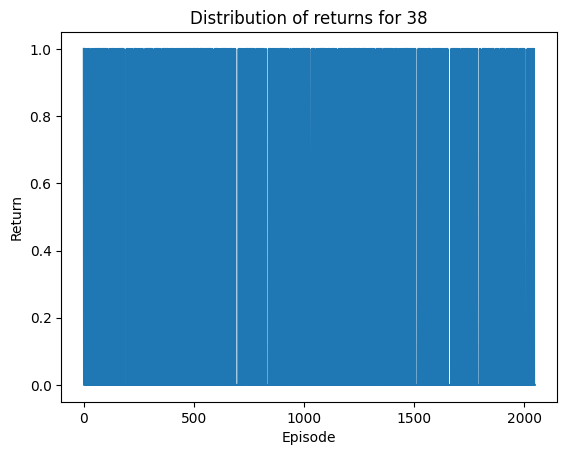

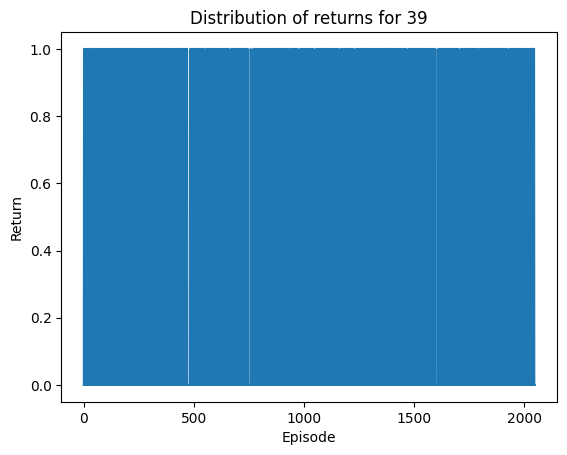

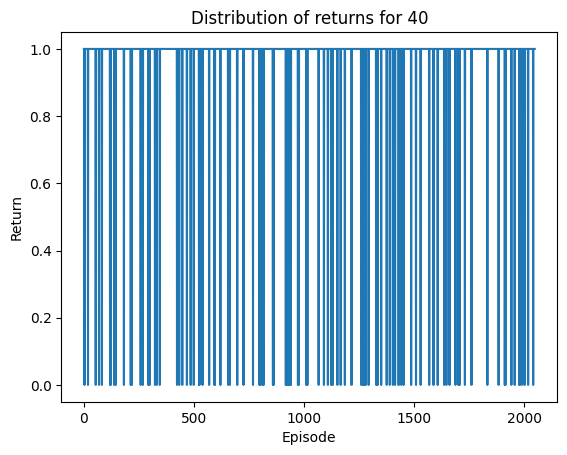

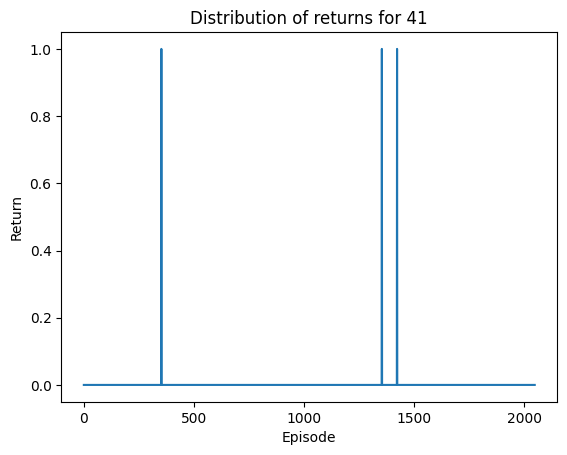

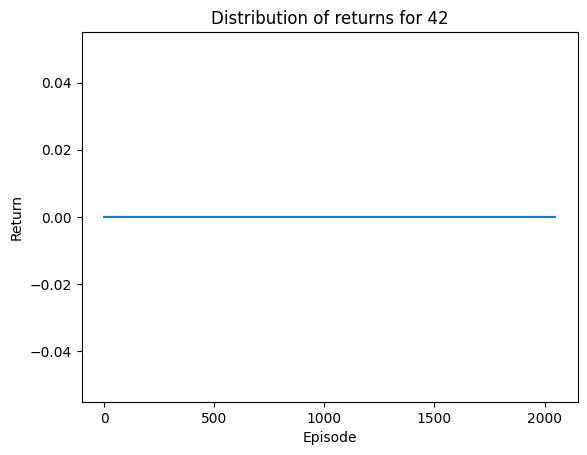

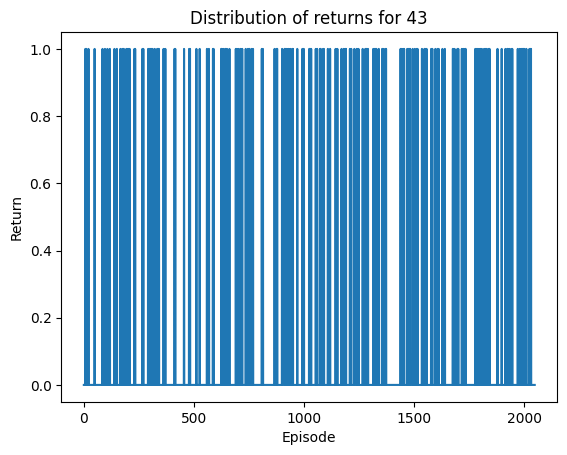

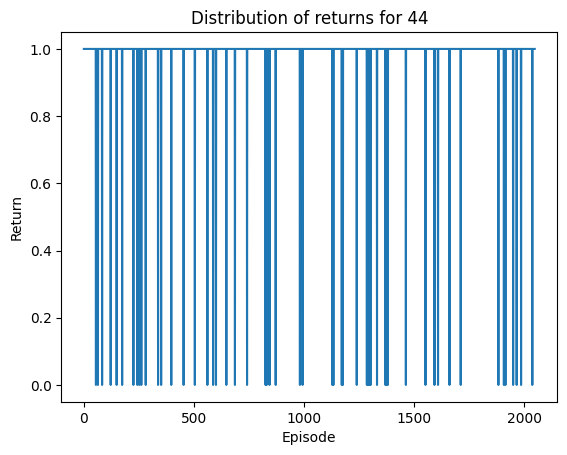

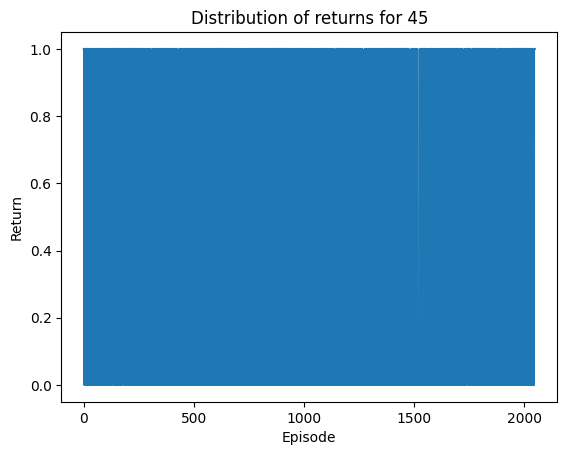

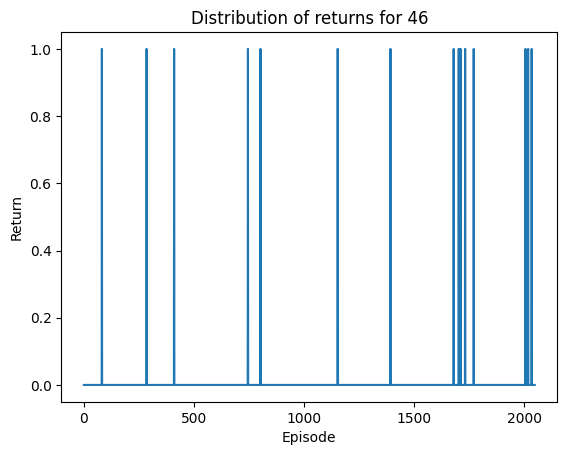

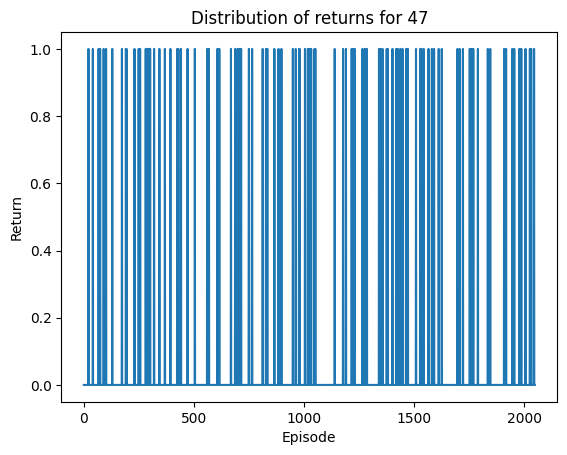

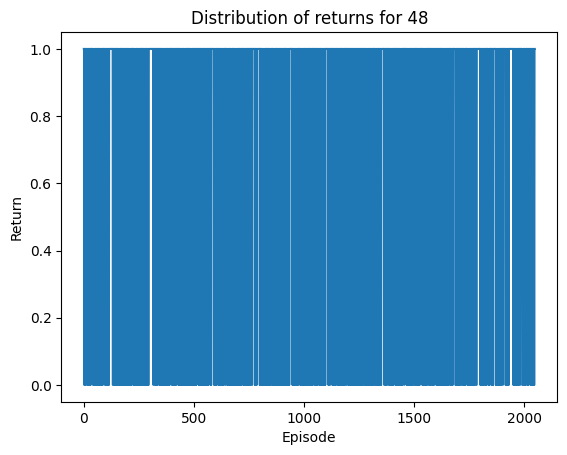

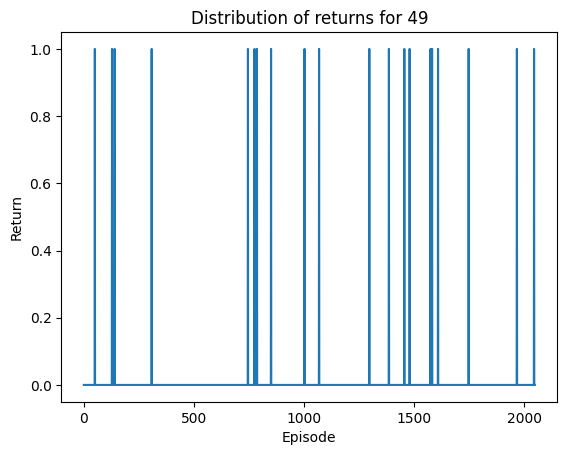

In [6]:
if algo_name.startswith("xland"):
    for k, v in data.items():
        plt.figure()
        plt.plot(range(len(v)), v, label=k)
        plt.title(f"Distribution of returns for {k}")
        plt.xlabel("Episode")
        plt.ylabel("Return")
        plt.show()
elif algo_name.startswith("bandit"):
    (num_envs, num_eps) = data["episode_length"].shape
    xrange = range(num_eps)
    print(data["env_params"])
    for env_i in range(num_envs):
        plt.plot(xrange, data["episode_return"][env_i], label=env_i)
        plt.title(f"Distribution of returns for {env_i}")
        plt.xlabel("Episode")
        plt.ylabel("Return")
        plt.show()